# Project: Recognizing Traffic Signs Using Deep Learning
### Scope: Dataset pre-processing with help of Sample Bsasline NN
##### Author: Ashish Panchal (epababl03.ashishp@iima.ac.in)

In [1]:
# Load/Import Libraries
import sys
import os
import numpy as np
import pandas as pd
import statistics
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from sklearn.utils import shuffle


import keras

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout 
from keras.layers.normalization import BatchNormalization
from keras import regularizers  
from keras.optimizers import SGD
from keras.layers import Flatten, Conv2D, MaxPooling2D 
from keras.callbacks import ModelCheckpoint

# Local python modules
sys.path.insert(0, os.path.abspath('../src/util'))
sys.path.insert(1, os.path.abspath('../src/data'))

from explore import list_images
from datapreprocessor import gray_scale
from datapreprocessor import local_histo_equalize
from datapreprocessor import image_normalize
from datapreprocessor import preprocess


Using TensorFlow backend.


In [2]:
#Load stored data

# No. of classes
%store -r n_classes

# class labels
%store -r signs

# Training Dataset
%store -r X_train
%store -r y_train

# Test Dataset
%store -r X_test
%store -r y_test


# Validation Dataset
%store -r X_valid
%store -r y_valid

basline_bench_mark_df = pd.DataFrame(columns=['Stage','loss', 'accuracy', 'training_size'])

# 3. Data Preprocessing 

### 3.1 Preprocessing Techniques
We have applied several preprocessing steps to the input images to achieve the best possible results. we have used the following preprocessing techniques:
1. Data Augmentation
    - Slight Rotation of Images
    - Image Translation
2. Shuffling
3. Bilateral Filtering
    - Grayscaling
    - Local Histogram Equalization
    - Normalization


Before we do any data preprocessing, lets have simple dense network to baseline quality of data on basis model accuracy.
#### Model Testing without any preprocessing - Establishing Baseline - Neural Network Architecture

In [5]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(32*32*3,)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))

In [6]:
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               393344    
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)              

In [7]:
X_train_baseline = X_train.reshape(len(X_train), 32*32*3).astype('float32')
X_valid_baseline = X_valid.reshape(len(X_valid), 32*32*3).astype('float32')
y_train_baseline = keras.utils.to_categorical(y_train, n_classes)
y_valid_baseline = keras.utils.to_categorical(y_valid, n_classes)

In [8]:
logdir = "../logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [9]:
base_history = model.fit(X_train_baseline, y_train_baseline, batch_size=128, 
                         epochs=100, verbose=1, callbacks=[tensorboard_callback], validation_data=(X_valid_baseline, y_valid_baseline))


Train on 34799 samples, validate on 4410 samples


Epoch 1/100
34799/34799 [==============================] - 9s 259us/step - loss: 2.6832 - accuracy: 0.2764 - val_loss: 1.7594 - val_accuracy: 0.5002

Epoch 2/100
34799/34799 [==============================] - 6s 173us/step - loss: 1.3334 - accuracy: 0.5874 - val_loss: 1.3745 - val_accuracy: 0.5769
Epoch 3/100
34799/34799 [==============================] - 6s 174us/step - loss: 0.9028 - accuracy: 0.7236 - val_loss: 0.8735 - val_accuracy: 0.7204
Epoch 4/100
34799/34799 [==============================] - 6s 172us/step - loss: 0.7704 - accuracy: 0.7640 - val_loss: 0.9180 - val_accuracy: 0.7100
Epoch 5/100
34799/34799 [==============================] - 6s 171us/step - loss: 0.6591 - accuracy: 0.7994 - val_loss: 0.9860 - val_accuracy: 0.7134
Epoch 6/100
34799/34799 [==============================] - 6s 183us/step - loss: 0.5883 - accuracy: 0.8215 - val_loss: 0.5962 - val_accuracy: 0.8249
Epoch 7/100
34799/34799 [============================

In [10]:
X_test_baseline = X_test.reshape(len(X_test), 32*32*3).astype('float32')
y_test_baseline = keras.utils.to_categorical(y_test, n_classes)

In [11]:
Pred = model.evaluate(X_test_baseline, y_test_baseline, verbose=0)
print("Dense fully connected network results on the test data - Baseline ")
print(" ")
print("%s- %.2f" % (model.metrics_names[0], Pred[0]))
print("%s- %.2f" % (model.metrics_names[1], Pred[1]))

Dense fully connected network results on the test data - Baseline 
 
loss- 0.57
accuracy- 0.88


In [ ]:
# model_json = model.to_json()
# with open("base_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("base_model.h5")
# print("Saved model to disk")
# from ann_visualizer.visualize import ann_viz;
# from keras.models import model_from_json
# import numpy
# # fix random seed for reproducibility
# numpy.random.seed(7)
# # load json and create model
# json_file = open('base_model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# # load weights into new model
# model.load_weights("base_model.h5")
# ann_viz(model, title="Artificial Neural network - Model Visualization")

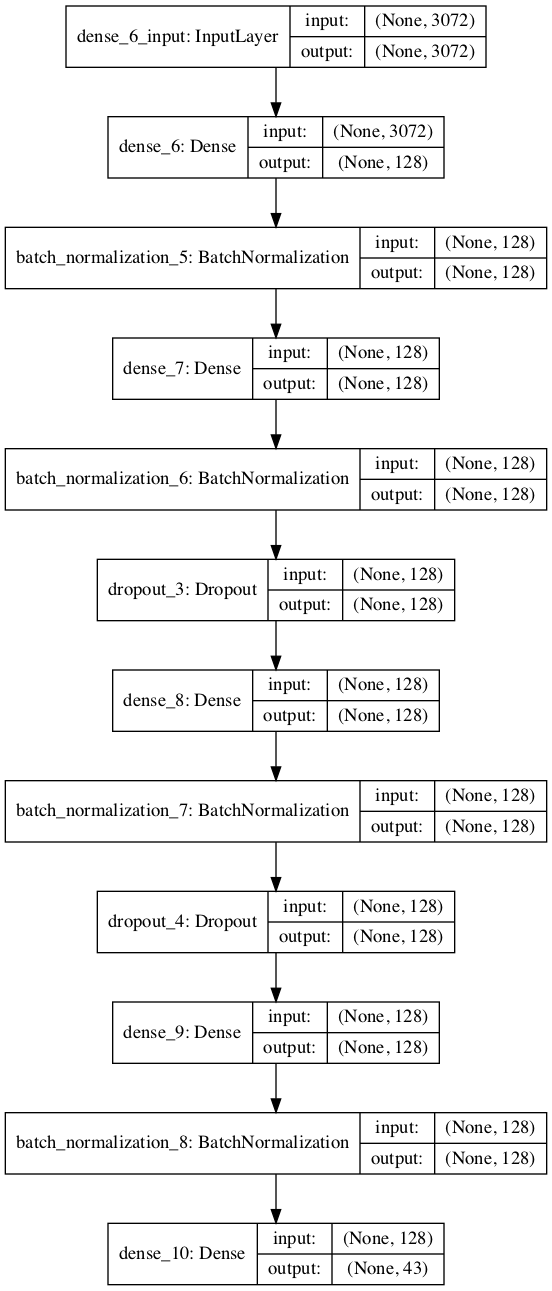

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='../plots/data_prep/base_model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
# list all data in history
print(base_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


In [14]:
basline_bench_mark_df.loc[1,'Stage'] = 'baseline'
basline_bench_mark_df.loc[1, 'loss'] = Pred[0]
basline_bench_mark_df.loc[1, 'accuracy'] = Pred[1]
basline_bench_mark_df.loc[1, 'training_size'] = len(X_train)
basline_bench_mark_df

,Stage,loss,accuracy,training_size
1,baseline,0.568218,0.882502,34799


In [15]:
basline_bench_mark_df.to_csv('../reports/data_benchmark_v1.csv', index = False, header=True)

## Visualize Model Training History
1. A plot of accuracy on the training and validation datasets over training epochs.
2. A plot of loss on the training and validation datasets over training epochs.



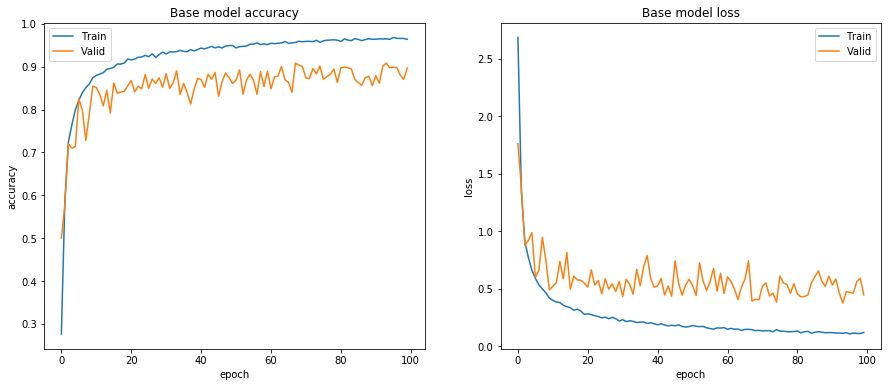

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6),sharex=True)
plt.xlabel('epoch')
axes[0].plot(base_history.history['accuracy'],label='Train')
axes[0].plot(base_history.history['val_accuracy'],label='Valid')
axes[0].set_title('Base model accuracy')
axes[0].legend()

axes[1].plot(base_history.history['loss'],label='Train')
axes[1].plot(base_history.history['val_loss'],label='Valid')
axes[1].set_title('Base model loss')
axes[1].legend()
# Set common labels
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('accuracy')
axes[1].set_ylabel('loss')
plt.savefig('../plots/data_prep/baseline_model_curve.png')
plt.show()

### 3.2	Data Augmentation

In [17]:
def data_augment(image):
    rows= image.shape[0]
    cols = image.shape[1]
    
    # rotation
    M_rot = cv2.getRotationMatrix2D((cols/2,rows/2),10,1)
    
    # Translation
    M_trans = np.float32([[1,0,3],[0,1,6]])
    
    
    img = cv2.warpAffine(image,M_rot,(cols,rows))
    img = cv2.warpAffine(img,M_trans,(cols,rows))
    #img = cv2.warpAffine(img,M_aff,(cols,rows))
    
    # Bilateral filtering
    img = cv2.bilateralFilter(img,9,75,75)
    return img

### Increase training set by augmentation and making all class size similar

In [18]:
classes = n_classes
X_train_final = X_train
y_train_final = y_train
X_aug_1 = []
Y_aug_1 = []

for i in range(0,classes):
    
    class_records = np.where(y_train==i)[0].size
    #print('class_records:',class_records)
    min_records = 500
    if class_records <= min_records:
        ovr_sample = min_records - class_records
        #print('ovr_sample:',ovr_sample)
        samples = X_train[np.where(y_train==i)[0]]
        X_aug = []
        Y_aug = [i] * ovr_sample
        
        for x in range(ovr_sample):
            img = samples[x % class_records]
            trans_img = data_augment(img)
            X_aug.append(trans_img)
            
        X_train_final = np.concatenate((X_train_final, X_aug), axis=0)
        y_train_final = np.concatenate((y_train_final, Y_aug)) 
        
        Y_aug_1 = Y_aug_1 + Y_aug
        X_aug_1 = X_aug_1 + X_aug

In [16]:
# classes = n_classes
# X_train_final = X_train
# y_train_final = y_train
# X_aug_1 = []
# Y_aug_1 = []

# for i in range(0,classes):
    
#     class_records = np.where(y_train==i)[0].size
#     #print('classbasline_bench_mark_dfords:',class_records)
#     max_records = 2010
#     if class_records != max_records:
#         ovr_sample = max_records - class_records
#         samples = X_train[np.where(y_train==i)[0]]
#         X_aug = []
#         Y_aug = [i] * ovr_sample
        
#         for x in range(ovr_sample):
#             img = samples[x % class_records]
#             trans_img = data_augment(img)
#             X_aug.append(trans_img)
            
#         X_train_final = np.concatenate((X_train_final, X_aug), axis=0)
#         y_train_final = np.concatenate((y_train_final, Y_aug)) 
        
#         Y_aug_1 = Y_aug_1 + Y_aug
#         X_aug_1 = X_aug_1 + X_aug

#### Check class bias after augmentation

[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42]
 [ 500 1980 2010 1260 1770 1650  500 1290 1260 1320 1800 1170 1890 1920
   690  540  500  990 1080  500  500  500  500  500  500 1350  540  500
   500  500  500  690  500  599  500 1080  500  500 1860  500  500  500
   500]]


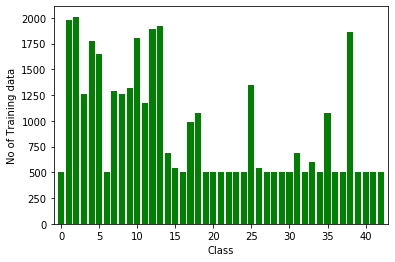

In [19]:
unique_elements, counts_elements = np.unique(y_train_final, return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

plt.bar( np.arange( 43 ), counts_elements, align='center',color='green' )
plt.xlabel('Class')
plt.ylabel('No of Training data')
plt.xlim([-1, 43])
plt.savefig('../plots/data_prep/data_aug_result.png')
plt.show()

### Shape of the datasets after data augmentation

In [20]:
print('Number of training examples and class labels, before data augmentation:',len(X_train),len(y_train))
print('Number of training examples and class labels, after data augmentation:',len(X_train_final),len(y_train_final))

Number of training examples and class labels, before data augmentation: 34799 34799
Number of training examples and class labels, after data augmentation: 39239 39239


## View images after data augmentation

 
 
Let's view few images to understand our transformations


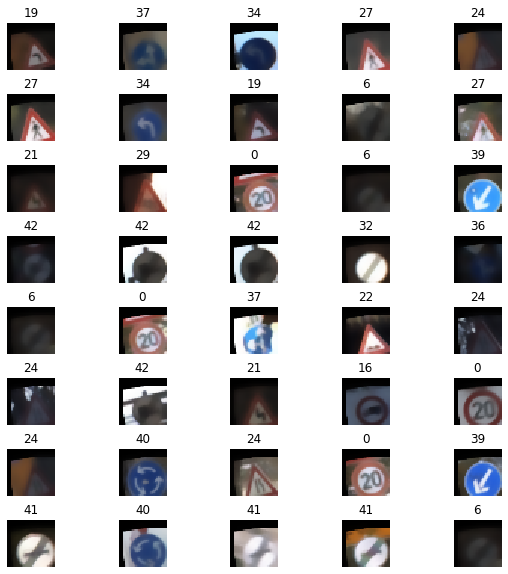

In [21]:
print(" ")
print(" ")
print("Let's view few images to understand our transformations")
fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = random.randint(0, len(X_aug_1))
    image = X_aug_1[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(Y_aug_1[index])

## Model Testing after Augmentation

In [22]:
X_train_aug = X_train_final.reshape(len(X_train_final), 32*32*3).astype('float32')
X_valid_aug = X_valid.reshape(len(X_valid), 32*32*3).astype('float32')
y_train_aug = keras.utils.to_categorical(y_train_final, n_classes)
y_valid_aug = keras.utils.to_categorical(y_valid, n_classes)

In [23]:
filepath="GTSRB_Baseline_Network_AfterAugmentation.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [24]:
aug_history =model.fit(X_train_aug, y_train_aug, batch_size=128, epochs=100, verbose=0,callbacks=[checkpoint],validation_data=(X_valid_aug, y_valid_aug))


Epoch 00001: val_accuracy improved from -inf to 0.90272, saving model to GTSRB_Baseline_Network_AfterAugmentation.hdf5

Epoch 00002: val_accuracy did not improve from 0.90272

Epoch 00003: val_accuracy did not improve from 0.90272

Epoch 00004: val_accuracy did not improve from 0.90272

Epoch 00005: val_accuracy did not improve from 0.90272

Epoch 00006: val_accuracy did not improve from 0.90272

Epoch 00007: val_accuracy did not improve from 0.90272

Epoch 00008: val_accuracy did not improve from 0.90272

Epoch 00009: val_accuracy did not improve from 0.90272

Epoch 00010: val_accuracy improved from 0.90272 to 0.90431, saving model to GTSRB_Baseline_Network_AfterAugmentation.hdf5

Epoch 00011: val_accuracy did not improve from 0.90431

Epoch 00012: val_accuracy did not improve from 0.90431

Epoch 00013: val_accuracy did not improve from 0.90431

Epoch 00014: val_accuracy did not improve from 0.90431

Epoch 00015: val_accuracy did not improve from 0.90431

Epoch 00016: val_accuracy di

## Preparing test data

In [25]:
X_test_aug = X_test.reshape(len(X_test), 32*32*3).astype('float32')
y_test_aug = keras.utils.to_categorical(y_test, n_classes)

In [26]:
model_1 = Sequential()
model_1.add(Dense(128, activation='relu', input_shape=(32*32*3,)))
model_1.add(BatchNormalization())
model_1.add(Dense(128, activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.5))
model_1.add(Dense(128, activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.5))
model_1.add(Dense(128, activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dense(n_classes, activation='softmax'))
model_1.load_weights("GTSRB_Baseline_Network_AfterAugmentation.hdf5")
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
Pred = model_1.evaluate(X_test_aug, y_test_aug, verbose=0)
print("Dense fully connected network results on the test data - After Data Augmentation ")
print(" ")
print("%s- %.2f" % (model_1.metrics_names[0], Pred[0]))
print("%s- %.2f" % (model_1.metrics_names[1], Pred[1]))

Dense fully connected network results on the test data - After Data Augmentation 
 
loss- 0.56
accuracy- 0.88


In [28]:
basline_bench_mark_df.loc[2,'Stage'] = 'After Data Augmentation'
basline_bench_mark_df.loc[2, 'loss'] = Pred[0]
basline_bench_mark_df.loc[2, 'accuracy'] = Pred[1]
basline_bench_mark_df.loc[2, 'training_size'] = len(X_train_final)

In [29]:
basline_bench_mark_df

,Stage,loss,accuracy,training_size
1,baseline,0.568218,0.882502,34799
2,After Data Augmentation,0.559971,0.884561,39239


## Applying pre-processing techniques

### Gray scaling

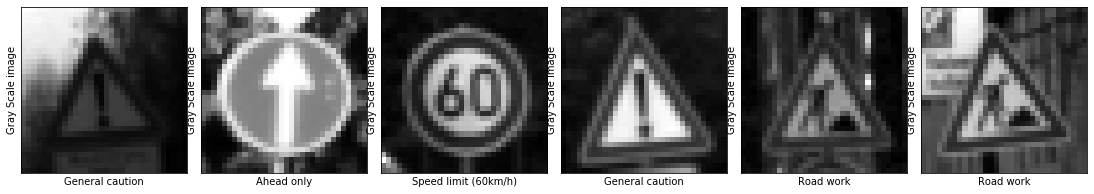

In [30]:
gray_images = list(map(gray_scale, X_train_final))
list_images(gray_images, y_train_final, "Gray Scale image", "gray")

 
 
Let's view few images to familiarize


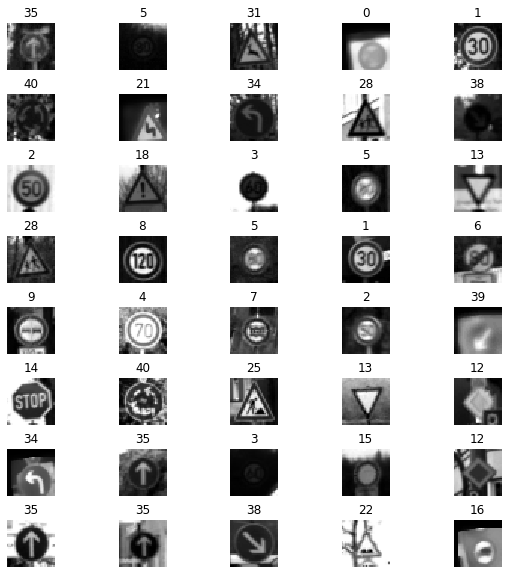

In [31]:
%matplotlib inline
print(" ")
print(" ")
print("Let's view few images to familiarize")
fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = np.random.randint(0, len(gray_images))
    image = gray_images[index]
    axs[i].axis('off')
    axs[i].imshow(image,cmap='gray')
    axs[i].set_title(y_train_final[index])
plt.savefig('../plots/data_prep/gray_scaling_Figure-3.4.png')   

### Local Histogram

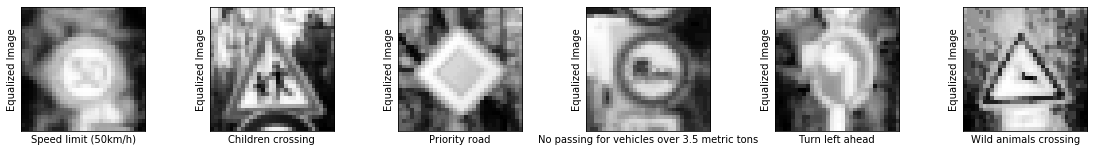

In [32]:
# Sample images after Local Histogram Equalization
equalized_images = list(map(local_histo_equalize, gray_images))
list_images(equalized_images, y_train_final, "Equalized Image", "gray")

 
 
Let's view few images after applying local histogram equilization and Gray scaling


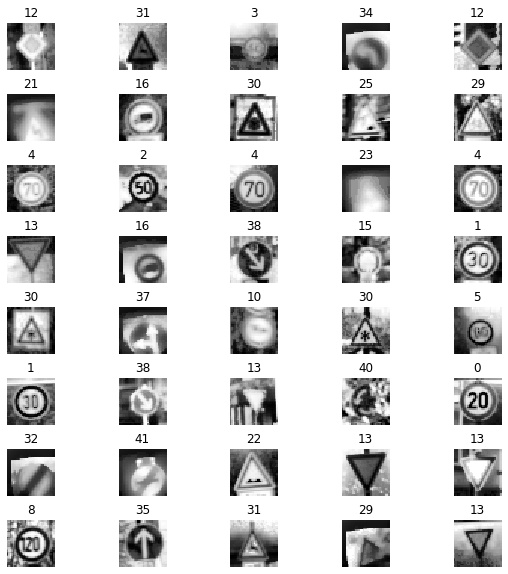

In [33]:
%matplotlib inline
print(" ")
print(" ")
print("Let's view few images after applying local histogram equilization and Gray scaling")
fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = np.random.randint(0, len(equalized_images))
    image = equalized_images[index]
    axs[i].axis('off')
    axs[i].imshow(image,cmap = 'gray')
    axs[i].set_title(y_train_final[index])
plt.savefig('../plots/data_prep/local_histo_Figure-3.5.png') 

### Normalization

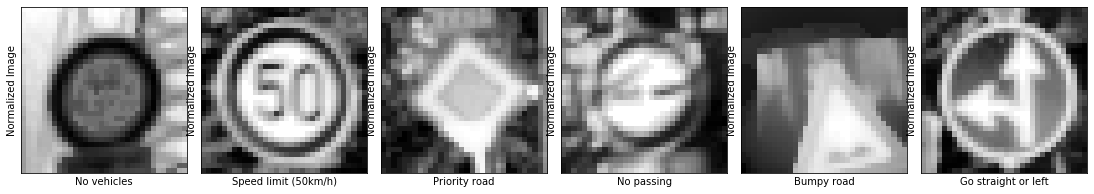

In [34]:
# Sample images after normalization
n_training = X_train_final.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
list_images(normalized_images, y_train_final, "Normalized Image", "gray")
normalized_images = normalized_images[..., None]

### Apply Grayscaling and local histogram equalization to the training and the validation data

In [35]:
X_train_preprocessed = preprocess(X_train_final)
X_valid_preprocessed = preprocess(X_valid)

In [36]:
X_train_preprocessed_dn = X_train_preprocessed.reshape(len(X_train_preprocessed), 32*32*1).astype('float32')
X_valid_preprocessed_dn = X_valid_preprocessed.reshape(len(X_valid_preprocessed), 32*32*1).astype('float32')

In [37]:
y_train_final_dn = keras.utils.to_categorical(y_train_final, n_classes)
y_valid_final_dn = keras.utils.to_categorical(y_valid, n_classes)

### Check the shape of the datasets after all preprocessing

In [38]:
print(X_train_preprocessed_dn.shape)
print(X_valid_preprocessed_dn.shape)
print(y_train_final_dn.shape)
print(y_valid_final_dn.shape)

(39239, 1024)
(4410, 1024)
(39239, 43)
(4410, 43)


## Compile and fit the model after preprocessing

In [39]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(32*32*1,)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Save model with Checkpoint

In [41]:
filepath="GTSRB_Basline_Network_final.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [51]:
final_history = model.fit(X_train_preprocessed_dn, y_train_final_dn, batch_size=128, epochs=125, 
          verbose=1,callbacks=callbacks_list,validation_data=(X_valid_preprocessed_dn, y_valid_final_dn))

Train on 39239 samples, validate on 4410 samples
Epoch 1/125
39239/39239 [==============================] - 8s 206us/step - loss: 0.2095 - accuracy: 0.9338 - val_loss: 0.4904 - val_accuracy: 0.8850

Epoch 00001: val_accuracy did not improve from 0.91020
Epoch 2/125
39239/39239 [==============================] - 6s 144us/step - loss: 0.2122 - accuracy: 0.9327 - val_loss: 0.5127 - val_accuracy: 0.8812

Epoch 00002: val_accuracy did not improve from 0.91020
Epoch 3/125
39239/39239 [==============================] - 6s 154us/step - loss: 0.2046 - accuracy: 0.9363 - val_loss: 0.5284 - val_accuracy: 0.8753

Epoch 00003: val_accuracy did not improve from 0.91020
Epoch 4/125
39239/39239 [==============================] - 6s 156us/step - loss: 0.2104 - accuracy: 0.9340 - val_loss: 0.4762 - val_accuracy: 0.8814

Epoch 00004: val_accuracy did not improve from 0.91020
Epoch 5/125
39239/39239 [==============================] - 6s 155us/step - loss: 0.2034 - accuracy: 0.9346 - val_loss: 0.4837 - val

### prepare test data for final results

In [43]:
## Prepare the Test data with all the preprocessing
X_test_preprocessed = preprocess(X_test)
X_test_preprocessed_dn = X_test_preprocessed.reshape(len(X_test_preprocessed), 32*32*1).astype('float32')
y_test_final_dn = keras.utils.to_categorical(y_test, n_classes)

### Load the best model from the validation data results¶

In [44]:
model.load_weights("GTSRB_Basline_Network_final.hdf5")

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
Pred = model.evaluate(X_test_preprocessed_dn, y_test_final_dn, verbose=0)
print("Dense fully connected network results on the test data")
print(" ")
print("%s- %.2f%%" % (model.metrics_names[0], Pred[0]*100))
print("%s- %.2f%%" % (model.metrics_names[1], Pred[1]*100))

Dense fully connected network results on the test data
 
loss- 51.40%
accuracy- 88.46%


In [47]:
basline_bench_mark_df.loc[3,'Stage'] = 'After Data Augmentation & Pre-processing'
basline_bench_mark_df.loc[3, 'loss'] = Pred[0]
basline_bench_mark_df.loc[3, 'accuracy'] = Pred[1]
basline_bench_mark_df.loc[3, 'training_size'] = len(X_train_final)

In [58]:
basline_bench_mark_df.to_csv('../reports/data_benchmark_v1.csv', index = False, header=True)

### Lets plot accuracy and loss curves

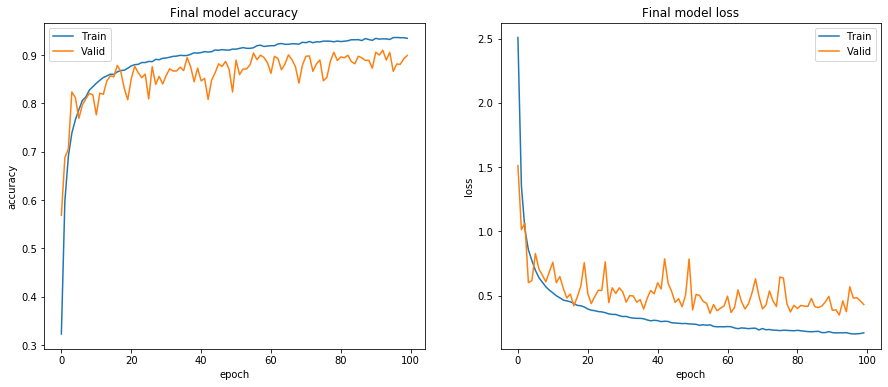

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6),sharex=True)
plt.xlabel('epoch')
axes[0].plot(final_history.history['accuracy'],label='Train')
axes[0].plot(final_history.history['val_accuracy'],label='Valid')
axes[0].set_title('Final model accuracy')
axes[0].legend()

axes[1].plot(final_history.history['loss'],label='Train')
axes[1].plot(final_history.history['val_loss'],label='Valid')
axes[1].set_title('Final model loss')
axes[1].legend()
# Set common labels
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('accuracy')
axes[1].set_ylabel('loss')
plt.savefig('../plots/data_prep/final_model_curve.png')
plt.show()

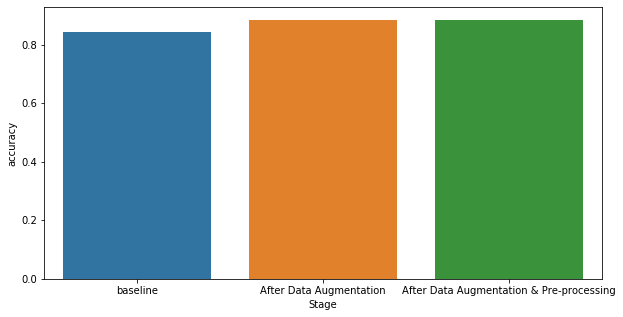

In [64]:
basline_bench_mark_csv_df = pd.read_csv('../reports/data_benchmark_v1.csv')
acre_fires_fig = plt.figure(figsize=(10,5))
sns.barplot(x='Stage',y='accuracy',data=basline_bench_mark_csv_df)
plt.savefig('../plots/data_prep/baseline.png')
plt.show()

In [57]:
# store main data for furthur procesing 



# Final preprocessed Training Dataset
%store X_train_preprocessed
%store y_train_final

# Final preprocessed Test Dataset
%store X_test_preprocessed
%store y_test


# Final preprocessed Validation Dataset
%store X_valid_preprocessed
%store y_valid

Stored 'X_train_preprocessed' (ndarray)
Stored 'y_train_final' (ndarray)
Stored 'X_test_preprocessed' (ndarray)
Stored 'y_test' (ndarray)
Stored 'X_valid_preprocessed' (ndarray)
Stored 'y_valid' (ndarray)
